# Fitting Saturation-based Simulation Data Changes
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. In this notebook, we try to fit the difference between 2 sets of measurements.


# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# V2

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization, generate_differential_data_loaders, DifferentialCombinationDataset
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity
from inverse_modelling_tfo.misc.misc_training import set_seed
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [2]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
# data = interpolate_exp(data, weights=[1, 0.8])
# data['Intensity'] = data['Interpolated Intensity']
# data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
0,10,-5.003564,1.0,6.0,12.0,0.9,0.11,0.1
1,14,-7.176319,1.0,6.0,12.0,0.9,0.11,0.1
2,19,-9.282155,1.0,6.0,12.0,0.9,0.11,0.1
3,23,-10.143438,1.0,6.0,12.0,0.9,0.11,0.1
4,28,-10.578727,1.0,6.0,12.0,0.9,0.11,0.1


In [68]:
# data1 = create_ratio(data, True)
# data2 = create_spatial_intensity(data)
# sim_params = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Fetal Hb Concentration", "Fetal Saturation", "Maternal Saturation"]
# data = pd.merge(data1, data2, how='inner', on=sim_params)

# data = create_ratio(data, True)

data = create_spatial_intensity(data)

data.head() 
# NOTE: Have only 1 on at the same time!

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-4.788235,-5.891256,-6.565637,-7.023905,-7.415765,...,-11.473209,-11.759999,-12.017859,-12.274537,-12.537797,-12.793837,-13.089528,-13.309907,-13.502396,-13.825513
1,2.0,12.0,0.9,0.11,0.225,-4.787676,-5.886830,-6.554969,-7.007363,-7.393859,...,-11.496584,-11.786246,-12.046478,-12.306739,-12.572414,-12.830995,-13.130074,-13.352649,-13.545234,-13.872506
2,2.0,12.0,0.9,0.11,0.350,-4.787082,-5.882115,-6.543582,-6.989645,-7.370265,...,-11.519309,-11.811729,-12.074236,-12.338013,-12.606005,-12.866975,-13.169270,-13.394052,-13.586719,-13.918002
3,2.0,12.0,0.9,0.11,0.475,-4.786448,-5.877066,-6.531360,-6.970551,-7.344683,...,-11.541401,-11.836468,-12.101154,-12.368376,-12.638587,-12.901793,-13.207129,-13.434124,-13.626866,-13.962007
4,2.0,12.0,0.9,0.11,0.600,-4.785766,-5.871626,-6.518150,-6.949820,-7.316720,...,-11.562880,-11.860482,-12.127251,-12.397845,-12.670178,-12.935463,-13.243663,-13.472877,-13.665692,-14.004523


In [69]:
# Cleanup
data.dropna(inplace=True)
data.head()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10_1.0,14_1.0,19_1.0,23_1.0,28_1.0,...,55_2.0,59_2.0,64_2.0,68_2.0,73_2.0,77_2.0,82_2.0,86_2.0,91_2.0,95_2.0
0,2.0,12.0,0.9,0.11,0.100,-4.788235,-5.891256,-6.565637,-7.023905,-7.415765,...,-11.473209,-11.759999,-12.017859,-12.274537,-12.537797,-12.793837,-13.089528,-13.309907,-13.502396,-13.825513
1,2.0,12.0,0.9,0.11,0.225,-4.787676,-5.886830,-6.554969,-7.007363,-7.393859,...,-11.496584,-11.786246,-12.046478,-12.306739,-12.572414,-12.830995,-13.130074,-13.352649,-13.545234,-13.872506
2,2.0,12.0,0.9,0.11,0.350,-4.787082,-5.882115,-6.543582,-6.989645,-7.370265,...,-11.519309,-11.811729,-12.074236,-12.338013,-12.606005,-12.866975,-13.169270,-13.394052,-13.586719,-13.918002
3,2.0,12.0,0.9,0.11,0.475,-4.786448,-5.877066,-6.531360,-6.970551,-7.344683,...,-11.541401,-11.836468,-12.101154,-12.368376,-12.638587,-12.901793,-13.207129,-13.434124,-13.626866,-13.962007
4,2.0,12.0,0.9,0.11,0.600,-4.785766,-5.871626,-6.518150,-6.949820,-7.316720,...,-11.562880,-11.860482,-12.127251,-12.397845,-12.670178,-12.935463,-13.243663,-13.472877,-13.665692,-14.004523


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [70]:
## Y -> Target
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
# y_columns = ['Maternal Saturation']
# y_columns = ['Maternal Hb Concentration']
y_column = 'Fetal Hb Concentration'
fixed_columns = ['Maternal Wall Thickness', "Fetal Saturation", "Maternal Saturation"]
# y_columns = ['Fetal Hb Concentration']

## X -> Predictors
# x_columns = list(filter(lambda X: '_' in X, data.columns))
# x_columns = list(filter(lambda X: X.isdigit(), data.columns))
x_columns = list(filter(lambda X: X.isdigit(), data.columns)) + list(filter(lambda X: '_' in X, data.columns))



## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_column] = y_scaler.fit_transform(data[y_column].to_numpy().reshape(-1, 1))

## Scale x
# I tried using the same scaling for all to preserve spatial information. Training does not work
# With variable scale the network learns how much weight to give each 
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])
## Manual scale - if needed (With maternal info.)
# data[x_columns[:-2]] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
# data[x_columns[:-2]] += 0.5  # unit var, 0 mean

## Scale non-intensity x columns (Maternal Hb Conc. , Maternal Saturation)
# data["Maternal Saturation"] -= 0.5 
# data["Maternal Hb Concentration"] /= 20
# data["Maternal Hb Concentration"] -= 0.5 


In [71]:
# Print Out Scaler values
# print(f'Y scale mean {y_scaler.mean_}')
# print(f'Y scale var {y_scaler.var_}')

In [72]:
data[y_column].value_counts()

-1.414214    1000
-0.707107    1000
 0.000000    1000
 0.707107    1000
 1.414214    1000
Name: Fetal Hb Concentration, dtype: int64

## Model Configuration

In [73]:
IN_FEATURES = len(x_columns) * 2
OUT_FEATURES = 1
model_config = {
    'model_class' : SplitChannelCNN,  # Class name
    # 'model_class' : PerceptronReLU,  # Class name
    # 'model_params' :  [2, IN_FEATURES, 4, 5, [2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 5, [6, 3, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [3, IN_FEATURES, 6, 7, [3, OUT_FEATURES]],    # Input params as an array
    'model_params' :  [4, IN_FEATURES, 8, 7, [4, 2, OUT_FEATURES]],    # Input params as an array
    # 'model_params' :  [[IN_FEATURES, 20, 8, OUT_FEATURES]],    # Input params as an array
    'train_split' : 0.8,
    'epochs' : 25,
    'total_data_len': 120000,
    'allow_zero_diff': False,
    'hyperparam_search_count': 20,
    'hyperparam_max_epoch': 10,
    'seed': 42
}

In [74]:
# Custom Train Function 
def train_model2(iteration_config, epoch=model_config['hyperparam_max_epoch']):
    set_seed(model_config['seed'])
    params = {
        'batch_size': iteration_config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    # train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
    train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config["allow_zero_diff"], model_config['train_split'])
    # model = create_perceptron_model(config['model'])
    # model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    model = model_config['model_class'](*model_config['model_params'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=iteration_config["lr"], momentum=iteration_config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [75]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([32, 16, 8]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.93, 0.95, 0.97]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=40, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=model_config['hyperparam_search_count'], resources_per_trial={"cpu": 4, "gpu": 0.05},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


2023-07-24 12:23:28,540	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2023-07-24 12:23:30 (running for 00:00:00.31)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-24_12-23-30
Number of trials: 20/20 (20 PENDING)


== Status ==
Current time: 2023-07-24 12:23:35 (running for 00:00:05.38)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-24_12-23-30
Number of trials: 20/20 (4 PENDING, 16 RUNNING)


== Status ==
Current time: 2023-07-24 12:23:40 (running for 00:00:10.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 

Trial name,combined_loss,train_loss,val_loss
train_model2_9253f_00000,2.17321,1.64012,1.32503
train_model2_9253f_00001,4.38474,2.10627,2.08176
train_model2_9253f_00002,0.265055,0.705913,0.375478
train_model2_9253f_00003,0.0424292,0.217242,0.195308
train_model2_9253f_00004,4.38589,2.08946,2.09906
train_model2_9253f_00005,0.0130987,0.147742,0.0886593
train_model2_9253f_00006,4.34938,2.08503,2.086
train_model2_9253f_00007,4.36061,2.10139,2.07511
train_model2_9253f_00008,4.3522,2.0998,2.07267
train_model2_9253f_00009,4.28783,2.06863,2.07278


== Status ==
Current time: 2023-07-24 12:23:55 (running for 00:00:25.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-24_12-23-30
Number of trials: 20/20 (4 PENDING, 16 RUNNING)


== Status ==
Current time: 2023-07-24 12:24:00 (running for 00:00:30.57)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-24_12-23-30
Number of trials: 20/20 (4 PENDING, 16 RUNNING)


== Status ==
Current time: 2023-07-24 12:24:05 (running for 00:00:35.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: N

2023-07-24 12:33:10,077	INFO tune.py:1148 -- Total run time: 581.54 seconds (580.01 seconds for the tuning loop).


== Status ==
Current time: 2023-07-24 12:33:10 (running for 00:09:40.01)
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: -0.6267032754316031 | Iter 5.000: -4.2885897826830375
Logical resource usage: 4.0/64 CPUs, 0.05/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-24_12-23-30
Number of trials: 20/20 (20 TERMINATED)
+--------------------------+------------+----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                  |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_9253f_00000 | TERMINATED | 169.237.32

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [76]:
best_trial.config

{'lr': 0.0003484753915362265, 'batch_size': 16, 'momentum': 0.95}

In [77]:
model_config

{'model_class': inverse_modelling_tfo.models.custom_models.SplitChannelCNN,
 'model_params': [4, 80, 8, 7, [4, 2, 1]],
 'train_split': 0.8,
 'epochs': 25,
 'total_data_len': 120000,
 'allow_zero_diff': False,
 'hyperparam_search_count': 20,
 'hyperparam_max_epoch': 10,
 'seed': 42}

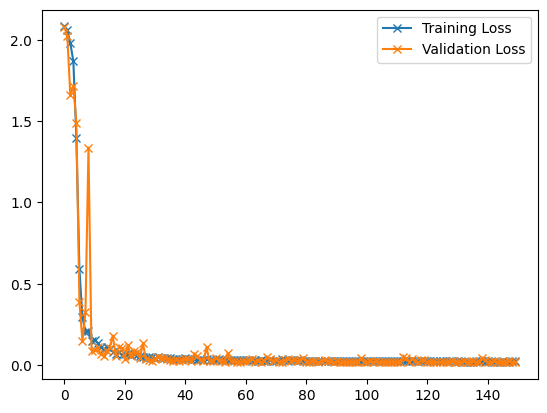

In [96]:
# Train Model with the given params.
set_seed(model_config['seed'])
params = {
    'batch_size': 8, 'shuffle': True, 'num_workers': 2
}
params['batch_size'] = best_trial.config['batch_size']
train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config["allow_zero_diff"], model_config['train_split'])
# train, val = generate_differential_data_loaders(data, params, fixed_columns, x_columns, y_column, 140000, model_config["allow_zero_diff"], model_config['train_split'])

model = model_config['model_class'](*model_config['model_params'])
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
# optimizer = SGD(model.parameters(), lr=0.0004, momentum=0.9)
optimizer = SGD(model.parameters(), lr=best_trial.config['lr'], momentum=best_trial.config['momentum'])
# CUDA_VISIBLE is already set to only see one GPU
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=150, gpu_to_use=0)
# train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=model_config['epochs'], gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [88]:
print(f'Train MSE : {train_loss[-1]}, Val MSE : {validation_loss[-1]}')

Train MSE : 0.024685320429853164, Val MSE : 0.016066946913177768


In [89]:
x_data = DifferentialCombinationDataset(data, fixed_columns, x_columns, y_column, model_config['total_data_len'], model_config['allow_zero_diff'])
truth_column = []
prediction_column = []
loss_column = []
tissue_fixed_params = []

with torch.no_grad():
    for i, current_sample in enumerate(x_data):
        inputs, labels = current_sample
        inputs = inputs.view(1, -1).cuda()
        labels = labels.view(1, -1).cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Bookkeeping
        truth_column.append(labels.item())
        prediction_column.append(outputs.item())
        loss_column.append(loss.item())
        tissue_fixed_params.append(x_data.split_fixed_columns[x_data.randomized_indices_list[i]])


tissue_fixed_params = np.array(tissue_fixed_params)
truth_column = np.array(truth_column).reshape(-1, 1)
prediction_column = np.array(prediction_column).reshape(-1, 1)
loss_column = np.array(loss_column).reshape(-1, 1)

# un-normalize
truth_column = y_scaler.scale_ * truth_column
prediction_column = y_scaler.scale_ * prediction_column
absolute_error = np.abs(truth_column - prediction_column)


merged = np.hstack([tissue_fixed_params, truth_column, prediction_column, loss_column, absolute_error])
merged_df = pd.DataFrame(merged, columns=fixed_columns + ['Truth', 'Predicted', "Train Error", "Absolute Error"])
merged_df.head()

,Maternal Wall Thickness,Fetal Saturation,Maternal Saturation,Truth,Predicted,Train Error,Absolute Error
0,16.0,0.225,0.975,0.000,0.003386,0.025472,0.003386
1,2.0,0.350,0.975,0.000,0.000998,0.002214,0.000998
2,6.0,0.350,1.000,0.000,0.000809,0.001453,0.000809
3,4.0,0.225,0.950,0.045,0.040775,0.039660,0.004225
4,6.0,0.100,0.900,-0.030,-0.025566,0.043696,0.004434


Text(0, 0.5, 'Count')

<Figure size 640x480 with 0 Axes>

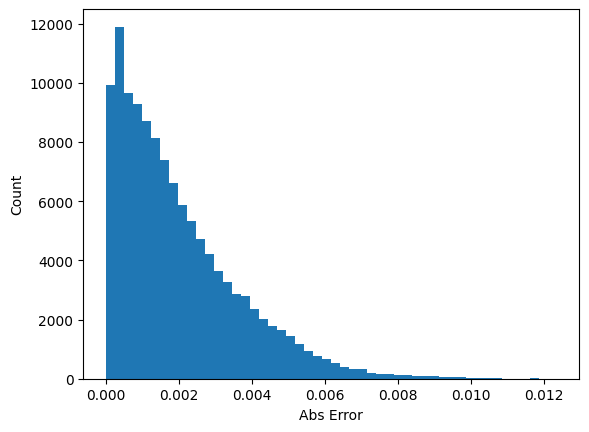

In [90]:
plt.figure()
plt.figure('Error Distribution')
plt.hist(merged_df['Absolute Error'], 50)
plt.xlabel('Abs Error')
plt.ylabel('Count')

In [92]:
merged_df['%Error'] = np.abs((merged_df['Truth'] - merged_df['Predicted'])) / merged_df['Truth'] * 100.

In [95]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = merged_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]
# worst_errors = merged_df['%Error'].argsort()[::-1][:VIEW_TOP_N]
with pd.option_context("display.max_rows", None):
    display(merged_df.iloc[worst_errors, :])

,Maternal Wall Thickness,Fetal Saturation,Maternal Saturation,Truth,Predicted,Train Error,Absolute Error,%Error
46328,4.0,0.600,1.000,-0.030,-0.017649,0.339005,0.012351,-41.170661
7687,4.0,0.600,1.000,-0.045,-0.032994,0.320308,0.012006,-26.679479
71857,4.0,0.600,1.000,-0.045,-0.032994,0.320308,0.012006,-26.679479
24623,4.0,0.600,1.000,-0.045,-0.032994,0.320308,0.012006,-26.679479
29121,4.0,0.600,1.000,-0.030,-0.018112,0.314073,0.011888,-39.627858
48699,4.0,0.475,1.000,-0.030,-0.018160,0.311530,0.011840,-39.467060
67643,4.0,0.475,1.000,-0.030,-0.018160,0.311530,0.011840,-39.467060
84820,4.0,0.475,1.000,-0.030,-0.018160,0.311530,0.011840,-39.467060
95158,4.0,0.475,1.000,-0.030,-0.018160,0.311530,0.011840,-39.467060
86702,4.0,0.600,1.000,-0.030,-0.018318,0.303258,0.011682,-38.939567


In [83]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [1.80640053e-05]
Validation Error(non-normalized): [1.6354547e-05]


In [84]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
SplitChannelCNN                          --
├─Conv1d: 1-1                            64
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       452
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       10
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       3
│    └─Flatten: 2-6                      --
Total params: 529
Trainable params: 529
Non-trainable params: 0

In [85]:
merged_df['Truth'].value_counts()

 0.000    20066
 0.015    20040
-0.015    19861
 0.030    15047
-0.030    14954
 0.045    10044
-0.045     9947
-0.060     5037
 0.060     5004
Name: Truth, dtype: int64